# Load Packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from os.path import join
from tqdm.auto import tqdm
import joblib
import torch
sys.path.append("../../")

from src.evaluation.consolidate import consolidate_pred_perf, consolidate_ue_perf, consolidate_pi_perf
from src.evaluation.perf_eval import display_pred_perf
from src.evaluation.ue_eval import display_ue_perf, restructure_ue_df
from src.evaluation.pi_eval import display_pi_perf, reorganise_pi_table, display_pi_perf_reorganised
from src.df_display.latex import df_to_latex, df_to_latex_grouped
from src.misc import create_folder
from ue_pi_dicts import pi_order
from src.df_display.heatmap import generate_pi_heatmap

seed_list=list(range(2023, 2023+5))
data_label = "physionet"
batch_size = 64

# File paths
fp_notebooks_folder = "../"
fp_project_folder = join(fp_notebooks_folder, "../")
fp_data_folder = join(fp_project_folder, "../", "data")
fp_output_data_folder = join(fp_data_folder, data_label)
fp_checkpoint_folder = join(fp_project_folder, "checkpoints")
fp_project_checkpoints = join(fp_checkpoint_folder, data_label)
fp_tuning = join(fp_project_checkpoints, "tuning")
fp_models = join(fp_project_checkpoints, "models")
fp_predictions = join(fp_project_checkpoints, "predictions")
fp_evaluation = join(fp_project_checkpoints, "model_evaluation")
fp_consolidated = join(fp_project_checkpoints, "consolidated_results")

2025-05-28 14:01:39.761458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 14:01:39.773218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 14:01:39.776915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 14:01:39.786439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 14:01:40.512398: W tensorflow/compiler/tf2

# Prediction Performance

In [2]:
pred_perf_df = consolidate_pred_perf(seed_list, fp_evaluation)
display_pred_perf(pred_perf_df, consolidated=True)
pred_perf_df.to_csv(join(fp_consolidated, "pred_perf.csv"))

,t+1,t+2,t+3
Model,,,
RUE,0.002 ± 0.000,0.0024 ± 0.000,0.0027 ± 0.000
MC Dropout,0.002 ± 0.000,0.0024 ± 0.000,0.0027 ± 0.000
GPR,0.0019 ± 0.000,0.0024 ± 0.000,0.0027 ± 0.000
Infer-Noise,0.002 ± 0.000,0.0024 ± 0.000,0.0027 ± 0.000
BNN,0.0052 ± 0.000,0.0053 ± 0.000,0.0053 ± 0.000
DER,0.0021 ± 0.000,0.0025 ± 0.000,0.003 ± 0.000


In [3]:
print(df_to_latex(pred_perf_df, column_format_dict={"t+1": "min", "t+2": "min", "t+3": "min"}))

\begin{tabular}{cccc}
 & \textbf{t+1} & \textbf{t+2} & \textbf{t+3} \\
Model &  &  &  \\
RUE & \underline{0.002 ± 0.000} & \textbf{0.0024 ± 0.000} & \textbf{0.0027 ± 0.000} \\
MC Dropout & \underline{0.002 ± 0.000} & \textbf{0.0024 ± 0.000} & \textbf{0.0027 ± 0.000} \\
GPR & \textbf{0.0019 ± 0.000} & \textbf{0.0024 ± 0.000} & \textbf{0.0027 ± 0.000} \\
Infer-Noise & \underline{0.002 ± 0.000} & \textbf{0.0024 ± 0.000} & \textbf{0.0027 ± 0.000} \\
BNN & 0.0052 ± 0.000 & 0.0053 ± 0.000 & 0.0053 ± 0.000 \\
DER & 0.0021 ± 0.000 & \underline{0.0025 ± 0.000} & \underline{0.003 ± 0.000} \\
\end{tabular}



# UE Performance

In [35]:
ue_perf_df = consolidate_ue_perf(seed_list, fp_evaluation, exclude_columns="Pval")
display_ue_perf(ue_perf_df, consolidated=True)

t+1


t+2


t+3


In [36]:
print(
    df_to_latex_grouped(
        ue_perf_df, 
        {"Corr": "max", "AURC":"min", "Sigma=0.1": "min", "Sigma=0.2": "min", "Sigma=0.3": "min", "Sigma=0.4": "min"})
)

\begin{tabular}{cccccccc}
\toprule
 &  & Corr & AURC & Sigma=0.1 & Sigma=0.2 & Sigma=0.3 & Sigma=0.4 \\
Time Horizon & Model &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{t+1} & RUE & \textbf{0.282 ± 0.014} & \underline{0.025 ± 0.001} & \textbf{0.02 ± 0.002} & \textbf{0.022 ± 0.001} & \textbf{0.024 ± 0.001} & \textbf{0.025 ± 0.001} \\
 & MC Dropout & 0.189 ± 0.012 & 0.026 ± 0.001 & 0.024 ± 0.001 & 0.025 ± 0.001 & 0.026 ± 0.001 & \underline{0.026 ± 0.001} \\
 & GPR & 0.174 ± 0.001 & \textbf{0.024 ± 0.000} & \underline{0.022 ± 0.000} & 0.024 ± 0.000 & \underline{0.025 ± 0.000} & \textbf{0.025 ± 0.000} \\
 & Infer-Noise & 0.057 ± 0.012 & 0.028 ± 0.001 & 0.028 ± 0.003 & 0.027 ± 0.001 & 0.028 ± 0.001 & 0.028 ± 0.001 \\
 & BNN & 0.122 ± 0.004 & 0.05 ± 0.000 & 0.049 ± 0.003 & 0.048 ± 0.001 & 0.049 ± 0.002 & 0.05 ± 0.001 \\
 & DER & \underline{0.236 ± 0.013} & \underline{0.025 ± 0.001} & \underline{0.022 ± 0.001} & \underline{0.023 ± 0.001} & \underline{0.025 ± 0.001} & \underline{0.026 ± 0

# PI Performance

In [4]:
pi_perf_df = consolidate_pi_perf(
    seed_list, fp_evaluation, selected_columns=["CovP", "PINAW", "PINAFD", "CWFDC"],
    pi_order=pi_order
)
display_pi_perf(pi_perf_df, consolidated=True)
pi_perf_df.to_csv(join(fp_consolidated, "pi_perf.csv"))

t+1:


t+2:


t+3:


## Heatmap

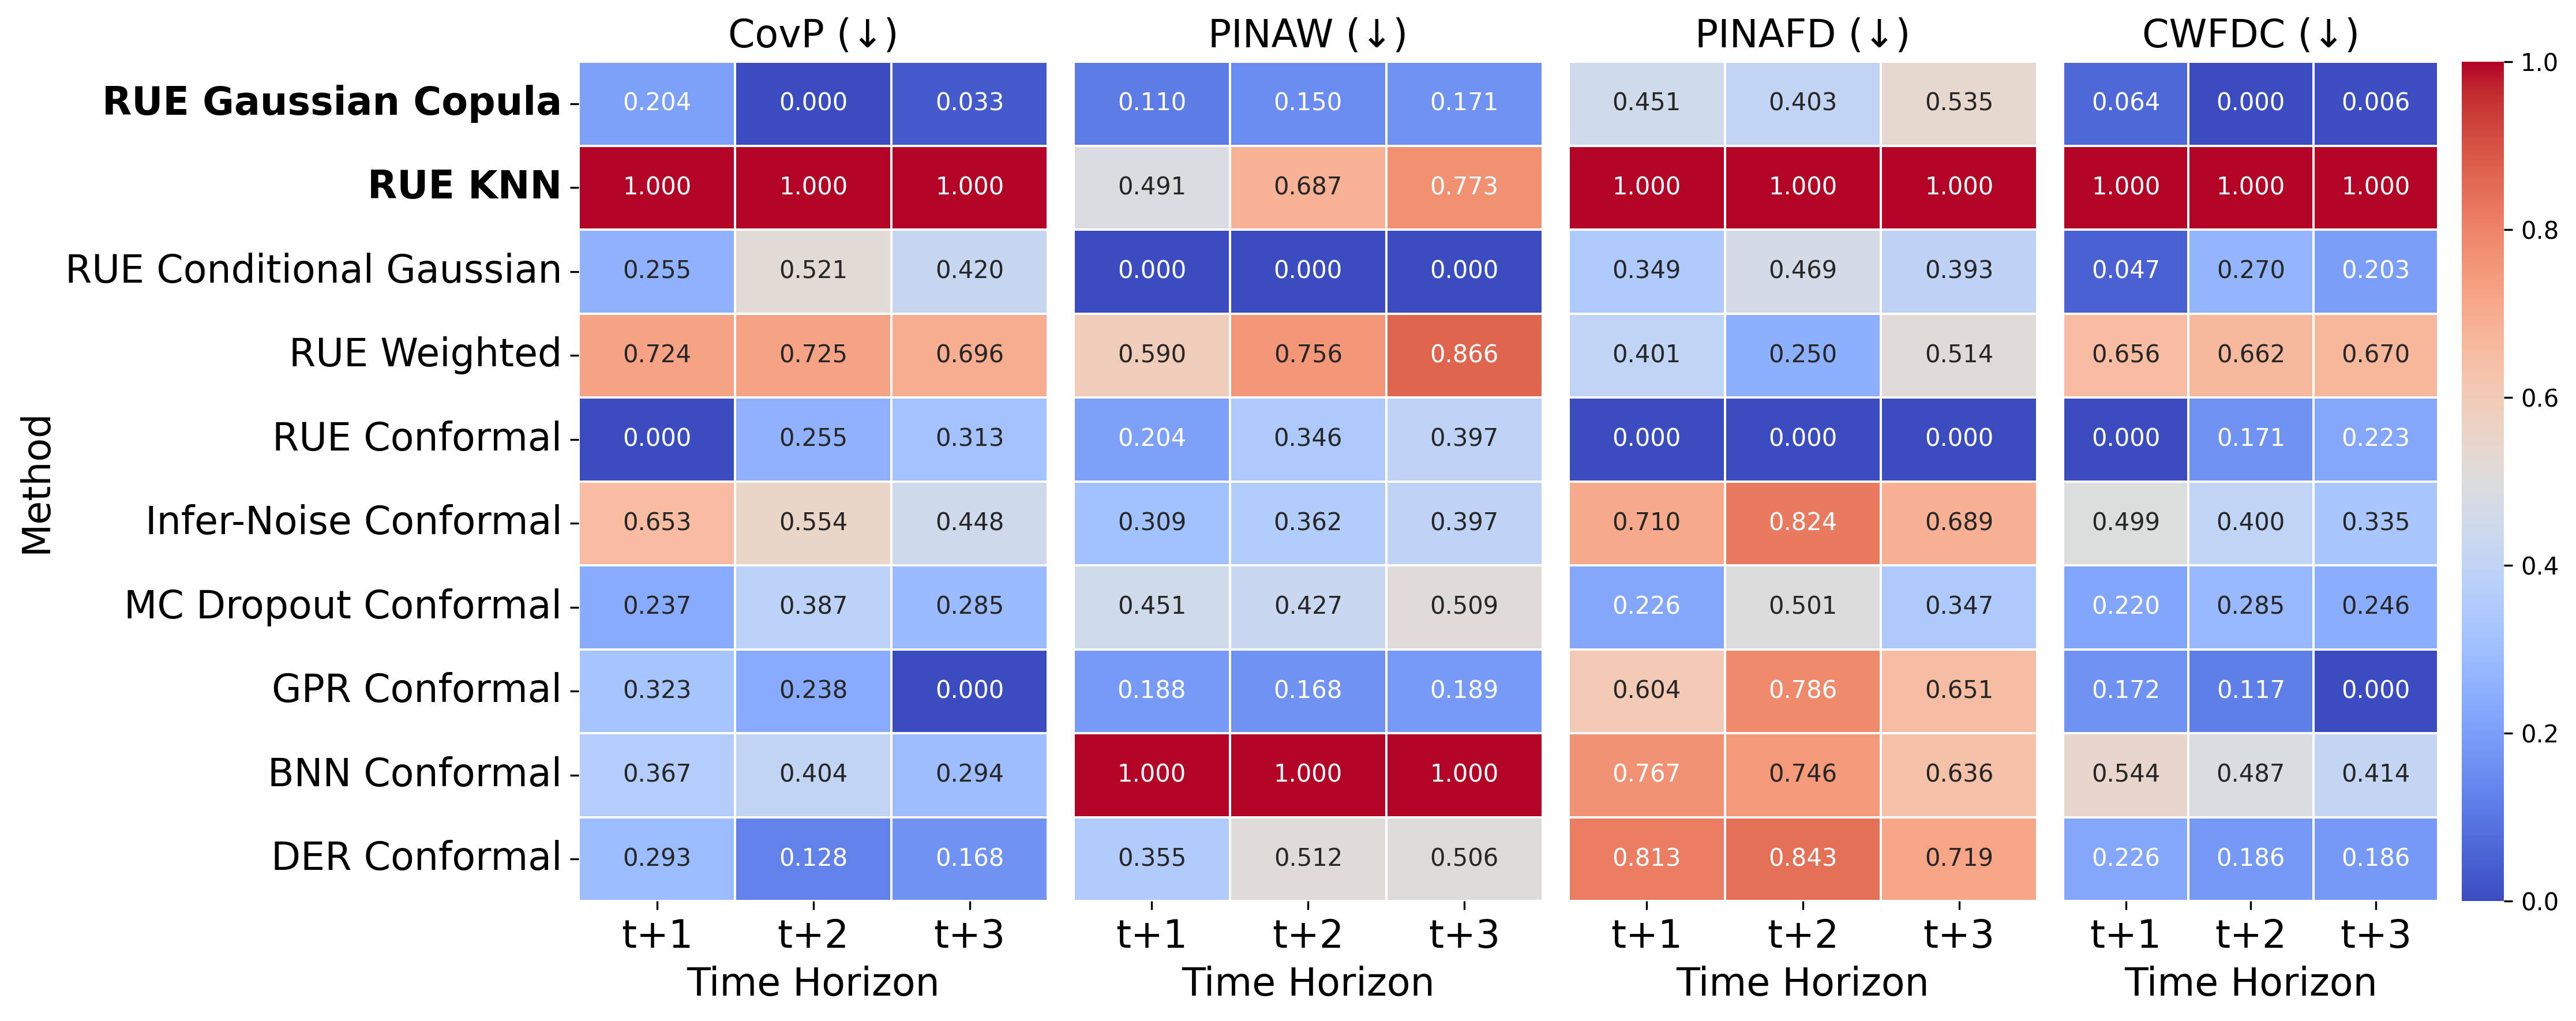

In [6]:
generate_pi_heatmap(
    seed_list, fp_evaluation=fp_evaluation, fp_consolidated=fp_consolidated, 
    bolded_methods=["RUE Gaussian Copula", "RUE KNN"], pi_order=pi_order, gamma=1, save_fig=True
)

## Reorganised Table

In [7]:
pi_perf_df_reorganised = reorganise_pi_table(
    seed_list, fp_evaluation, pi_order, selected_columns=["CovP", "PINAW", "PINAFD", "CWFDC"],
)
pi_perf_df_reorganised = pi_perf_df_reorganised.drop(columns=[f"CWFDC\nt+{i+1}" for i in range(3)])
display_pi_perf_reorganised(pi_perf_df_reorganised)

,CovP t+1,CovP t+2,CovP t+3,CovP Avg,PINAW t+1,PINAW t+2,PINAW t+3,PINAW Avg,PINAFD t+1,PINAFD t+2,PINAFD t+3,PINAFD Avg,CWFDC Avg
RUE Gaussian Copula,0.000078,0.000048,0.000087,0.000071,0.220747,0.244860,0.258511,0.241373,0.054071,0.054964,0.056793,0.055276,0.367809
RUE KNN,0.000549,0.000572,0.000625,0.000582,0.282885,0.323403,0.346327,0.317538,0.060681,0.059700,0.061325,0.060569,0.960163
RUE Conditional Gaussian,0.000089,0.000175,0.000191,0.000152,0.205437,0.226541,0.237957,0.223312,0.052928,0.055469,0.055471,0.054622,0.429669
RUE Weighted,0.000280,0.000290,0.000336,0.000302,0.301537,0.335172,0.362325,0.333011,0.053507,0.053814,0.056592,0.054638,0.689481
RUE Conformal,0.000048,0.000090,0.000154,0.000097,0.234596,0.271010,0.288449,0.264685,0.049188,0.051985,0.051982,0.051052,0.412978
Infer-Noise Conformal,0.000235,0.000190,0.000202,0.000209,0.251246,0.273313,0.288549,0.271036,0.057092,0.058262,0.058255,0.057870,0.538131
MC Dropout Conformal,0.000085,0.000126,0.000145,0.000119,0.275461,0.282620,0.304647,0.287576,0.051574,0.055714,0.055047,0.054111,0.460352
GPR Conformal,0.000105,0.000087,0.000081,0.000091,0.232113,0.247106,0.260827,0.246682,0.055843,0.057960,0.057891,0.057231,0.394886
BNN Conformal,0.000117,0.000131,0.000148,0.000132,0.393886,0.380389,0.386592,0.386956,0.057784,0.057640,0.057741,0.057722,0.576525
DER Conformal,0.000097,0.000066,0.000114,0.000093,0.258841,0.295331,0.304171,0.286114,0.058346,0.058418,0.058541,0.058435,0.437204


## Time-Method Table

In [8]:
print(
    df_to_latex_grouped(
        pi_perf_df, 
        {"PINAW":"min", "PINAFD": "min", "CovP":"min", "CWFDC":"min"})
)

\begin{tabular}{cccccc}
\toprule
 &  & CovP & PINAW & PINAFD & CWFDC \\
Time Horizon & Method &  &  &  &  \\
\midrule
\multirow[t]{10}{*}{t+1} & RUE Gaussian Copula & \underline{8e-05 ± 0.000} & \underline{0.22075 ± 0.002} & 0.05407 ± 0.001 & 0.35331 ± 0.011 \\
 & RUE KNN & 0.00055 ± 0.000 & 0.28288 ± 0.006 & 0.06068 ± 0.001 & 0.893 ± 0.064 \\
 & RUE Conditional Gaussian & 9e-05 ± 0.000 & \textbf{0.20544 ± 0.001} & 0.05293 ± 0.001 & \underline{0.34739 ± 0.014} \\
 & RUE Weighted & 0.00028 ± 0.000 & 0.30154 ± 0.006 & 0.05351 ± 0.001 & 0.63474 ± 0.030 \\
 & RUE Conformal & \textbf{5e-05 ± 0.000} & 0.2346 ± 0.004 & \textbf{0.04919 ± 0.001} & \textbf{0.33146 ± 0.014} \\
 & Infer-Noise Conformal & 0.00024 ± 0.000 & 0.25125 ± 0.004 & 0.05709 ± 0.001 & 0.54378 ± 0.033 \\
 & MC Dropout Conformal & 9e-05 ± 0.000 & 0.27546 ± 0.006 & \underline{0.05157 ± 0.001} & 0.41215 ± 0.015 \\
 & GPR Conformal & 0.00011 ± 0.000 & 0.23211 ± 0.000 & 0.05584 ± 0.000 & 0.39299 ± 0.001 \\
 & BNN Conformal & 0.000